# Multimessenger Package Refactor Tests

On 21/02/2023 <br>
After I refactored a lot of things in the package, now I would like to test WFSim simulations and iron out the details.

In [1]:
import numpy as np
import astropy.units as u
from snewpy.neutrino import Flavor
from multimessenger.supernova import Supernova_Models
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
# plt.style.use('/home/melih/software/multimessenger/multimessenger/supernova/customstyle.mplstyle')

In [3]:
import configparser
config = configparser.ConfigParser()
config['paths'] = {'snewpy_models': './mma_data/SNEWPY_models/',
                   'processed_data': './mma_data/',}
config['wfsim'] = {'instruction_path': './mma_data/',
                   'sim_folder': './mma_data/',}
with open('./mma_data/temp_config.config', 'w') as configfile:
    config.write(configfile)

I manually created a folder called `mma_data` and inside it I called <br>
`python -c 'import snewpy; snewpy.get_models()'` <br>
and installed 2 snewpy models. They are saved in `mma_data/SNEWPY_models/` which we give to config file. <br>

I store everything else in the same folder for now. Notice, normally, you don't want to keep (especially) heavy files in your home folder. The ideal would be to store all in the common /dali/ storage where everyone can load the same file instead of everyone creating it for themselves.

In [4]:
# create nakazato model 
SN_Nakazato = Supernova_Models.Models("Nakazato_2013", config_file="./mma_data/temp_config.config")
# call the model by filename or index
SN_Nakazato(index=5) # brings the attributes

> Nakazato_2013 is created, load a progenitor by function call.
> You chose ~wisely~ ->	   [5]	nakazato-shen-z0.004-t_rev200ms-s50.0.fits
>>>>> Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-s50_0_fits.pickle
> Retrieving object self.storageNakazato_2013-nakazato-shen-z0_004-t_rev200ms-s50_0_fits.pickle


/home/melih/software/multimessenger/multimessenger/supernova/snewpy_models.py:85: FutureWarning: Initializing this model with a filename is deprecated. Instead, use keyword arguments ['progenitor_mass', 'revival_time', 'metallicity', 'eos']. See `Nakazato_2013.param`, `Nakazato_2013.get_param_combinations()` for more info.
  models_dict[self.name](f)
/home/melih/software/multimessenger/multimessenger/supernova/snewpy_models.py:66: FutureWarning: Initializing this model with a filename is deprecated. Instead, use keyword arguments ['progenitor_mass', 'revival_time', 'metallicity', 'eos']. See `Nakazato_2013.param`, `Nakazato_2013.get_param_combinations()` for more info.
  model = models_dict[self.name](file_to_load, **model_kwargs)


In [5]:
# alternativley you can change them on the fly
SN_Nakazato.compute_model_fluxes(neutrino_energies=np.linspace(0, 150, 200), force=0)
fluxes_at10 = SN_Nakazato.scale_fluxes(distance=10)

Fluxes already exist in `self.fluxes`, and force=False, doing nothing.


In [6]:
print(f"The processed data will be saved here: {SN_Nakazato.storage}")

The processed data will be saved here: ./mma_data/


In [7]:
from multimessenger.supernova.Nucleus import Target
from multimessenger.supernova.Xenon_Atom import ATOM_TABLE
from multimessenger.supernova.interactions import Interactions

In [8]:
Int = Interactions(SN_Nakazato, Nuclei='Xenon', isotope='mix')

> Saved at <self.storage>/Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-s50_0_fits_interaction.pickle!



In [9]:
Int.compute_interaction_rates()

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

> Computed the total rates at the source for 1 atom (not scaled)


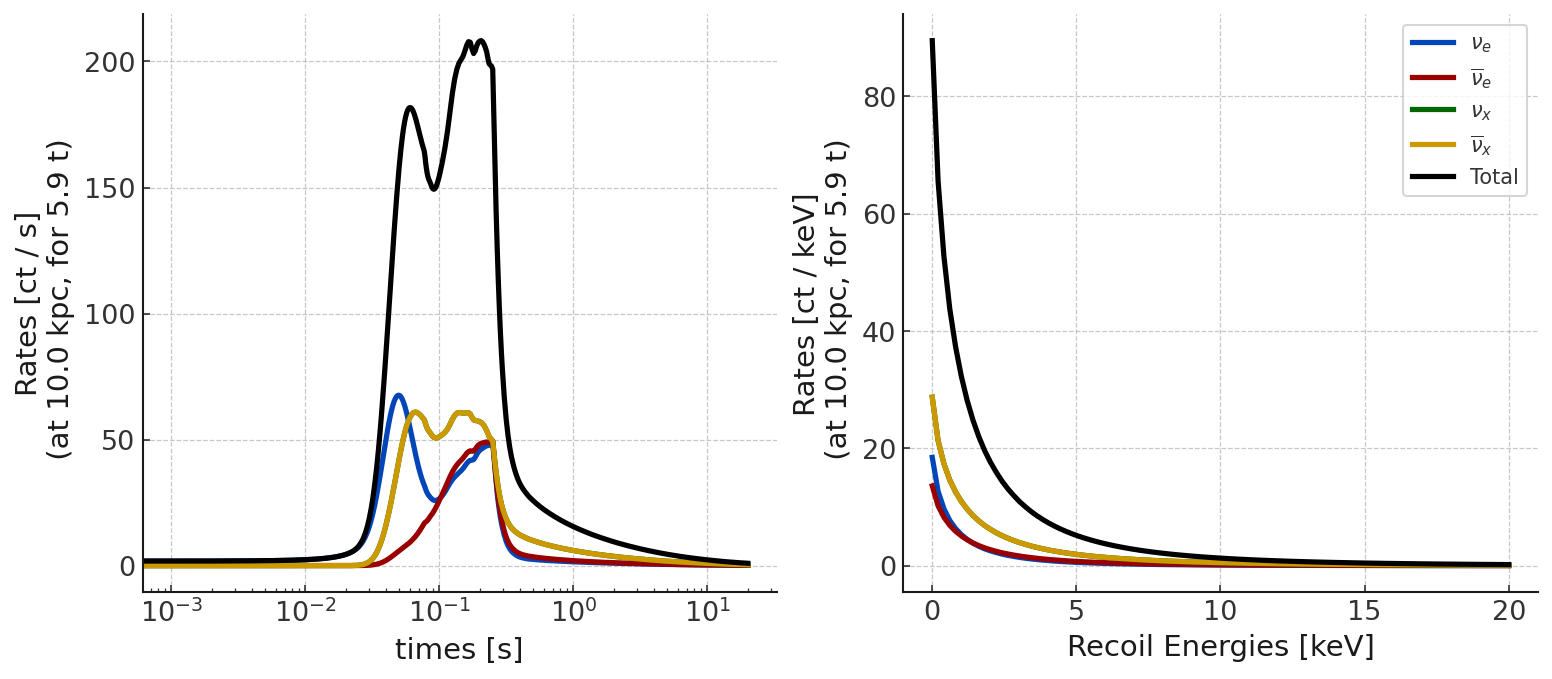

In [34]:
Int.scale_rates(distance=10, volume=5.9);
Int.plot_rates(scaled=True)

# Simulations

There are some functions to sample data and call simulations. I made a method of the class `simulate_automatically()` which does what it says.

In [11]:
import cutax

Could not import editors, GUI not available.


In [12]:
st = cutax.contexts.xenonnt_sim_SR0dev_cmt_v9()

/dali/lgrandi/xenonnt/software/cutax/v1.14.1/cutax/contexts.py:120: UserWarning: WARNING! You are using SR0_DEV simulation context! Consider updating to a newer/pinned version (SR0_V3)!
  warnings.warn(f'WARNING! You are using {faxconf_version.upper()} simulation context!'
*** Detector definition message ***
You are currently using the default XENON10 template detector.



In [13]:
# !rm -r strax_data/snsim*
# !rm -r mma_data/strax_data/snsim*

In [14]:
instructions = Int.simulate_automatically(context = st,
                                          runid="snsim_test",
                                          return_instructions=True,
                                          field=20)

NU_E:   0%|          | 0/18 [00:00<?, ?it/s]

NU_E_BAR:   0%|          | 0/18 [00:00<?, ?it/s]

NU_X:   0%|          | 0/43 [00:00<?, ?it/s]

NU_X_BAR:   0%|          | 0/43 [00:00<?, ?it/s]

/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/straxen/storage/mongo_storage.py:340: DownloadWarning: Downloading fieldmap_2D_B2d75n_C2d75n_G0d3p_A4d9p_T0d9n_PMTs1d3n_FSR0d65p_QPTFE_0d5n_0d4p.json.gz to /tmp/straxen_resource_cache/5dbdf9cdd30f4c440655a8e03e6301bc
  warn(f'Downloading {config_name} to {destination_path}',


> `nc` is not passed, Using default nestpy instance nestpy.DetectorExample_XENON10()
snsim_test already exists!
snsim_test is fetched! Returning context!


*** Detector definition message ***
You are currently using the default XENON10 template detector.



In [15]:
st.storage

[strax.storage.files.DataDirectory, path: ./strax_data,
 strax.storage.files.DataDirectory, path: ./mma_data/strax_data]

In [16]:
instructions[1]

,event_number,type,time,x,y,z,amp,recoil,e_dep,g4id,vol_id,local_field,n_excitons,x_pri,y_pri,z_pri
0,1,1,72553323,31.912748,-36.501499,-10.166192,10,0,1.712138,0,0,28.550296,8,0.0,0.0,0.0
1,1,2,72553323,31.912748,-36.501499,-10.166192,11,0,1.712138,0,0,28.550296,8,0.0,0.0,0.0
2,2,1,94775949,-28.331917,-37.371773,-133.554520,6,0,1.178169,0,0,22.672327,5,0.0,0.0,0.0
3,2,2,94775949,-28.331917,-37.371773,-133.554520,7,0,1.178169,0,0,22.672327,5,0.0,0.0,0.0
4,3,1,122468211,15.114445,-19.834782,-107.614784,20,0,3.150008,0,0,22.161157,17,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,120,2,16706778432,47.020214,43.083092,-60.873894,13,0,2.025827,0,0,21.573116,10,0.0,0.0,0.0
201,121,1,17297406026,-33.872200,-2.404505,-15.755183,1,0,0.563298,0,0,26.233791,1,0.0,0.0,0.0
202,121,2,17297406026,-33.872200,-2.404505,-15.755183,5,0,0.563298,0,0,26.233791,1,0.0,0.0,0.0
203,122,1,17411492042,39.294704,49.445389,-39.309841,2,0,1.045641,0,0,21.889123,2,0.0,0.0,0.0


In [17]:
# st = instructions[0]
peaks = st.get_df("snsim_test", "peak_basics")

Loading peak_basics: |          | 0.00 % [00:00<?]

In [18]:
peaks

,time,endtime,center_time,area,n_hits,n_channels,max_pmt,max_pmt_area,n_saturated_channels,range_50p_area,range_90p_area,area_fraction_top,length,dt,rise_time,tight_coincidence,type
0,58828110,58834310,58830225,111.402168,71,43,42,20.061417,0,2024.592163,5065.873047,0.802476,155,40,1851.155029,8,2
1,68277400,68300800,68290124,241.777893,175,108,92,22.610764,0,4729.087891,22738.160156,0.799151,195,120,12263.546875,16,2
2,70067440,70067770,70067539,5.165857,3,3,19,2.814419,0,57.851151,163.041870,0.688769,33,10,36.047226,3,1
3,71007470,71014910,71010765,151.188309,107,77,92,23.019417,0,6215.730469,6820.211426,0.780985,186,40,3124.629395,10,2
4,86404400,86404720,86404490,14.055478,9,9,369,2.720471,0,50.570068,158.438568,0.073820,32,10,30.225098,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,16429057810,16429063150,16429060771,200.049210,140,91,46,13.871298,0,2696.421875,4733.209473,0.738807,178,30,2350.082275,14,2
143,17117479880,17117480260,17117479981,10.292226,7,7,84,1.916884,0,93.126617,183.048416,0.514501,38,10,30.152145,6,1
144,17117774070,17117785530,17117779347,848.169800,594,238,36,83.432167,0,3299.952637,7792.874023,0.753097,191,60,2626.014893,23,2
145,19757803010,19757803870,19757803319,20.009495,14,13,96,2.689167,0,334.932007,604.368042,0.755830,86,10,289.247803,5,2


In [20]:
peak_s1 = peaks[peaks['type'] == 1]
peak_s2 = peaks[peaks['type'] == 2]
peaks['type'].unique(), sum(peaks['type']==0), sum(peaks['type']==1), sum(peaks['type']==2)

(array([2, 1, 0], dtype=int8), 2, 48, 97)

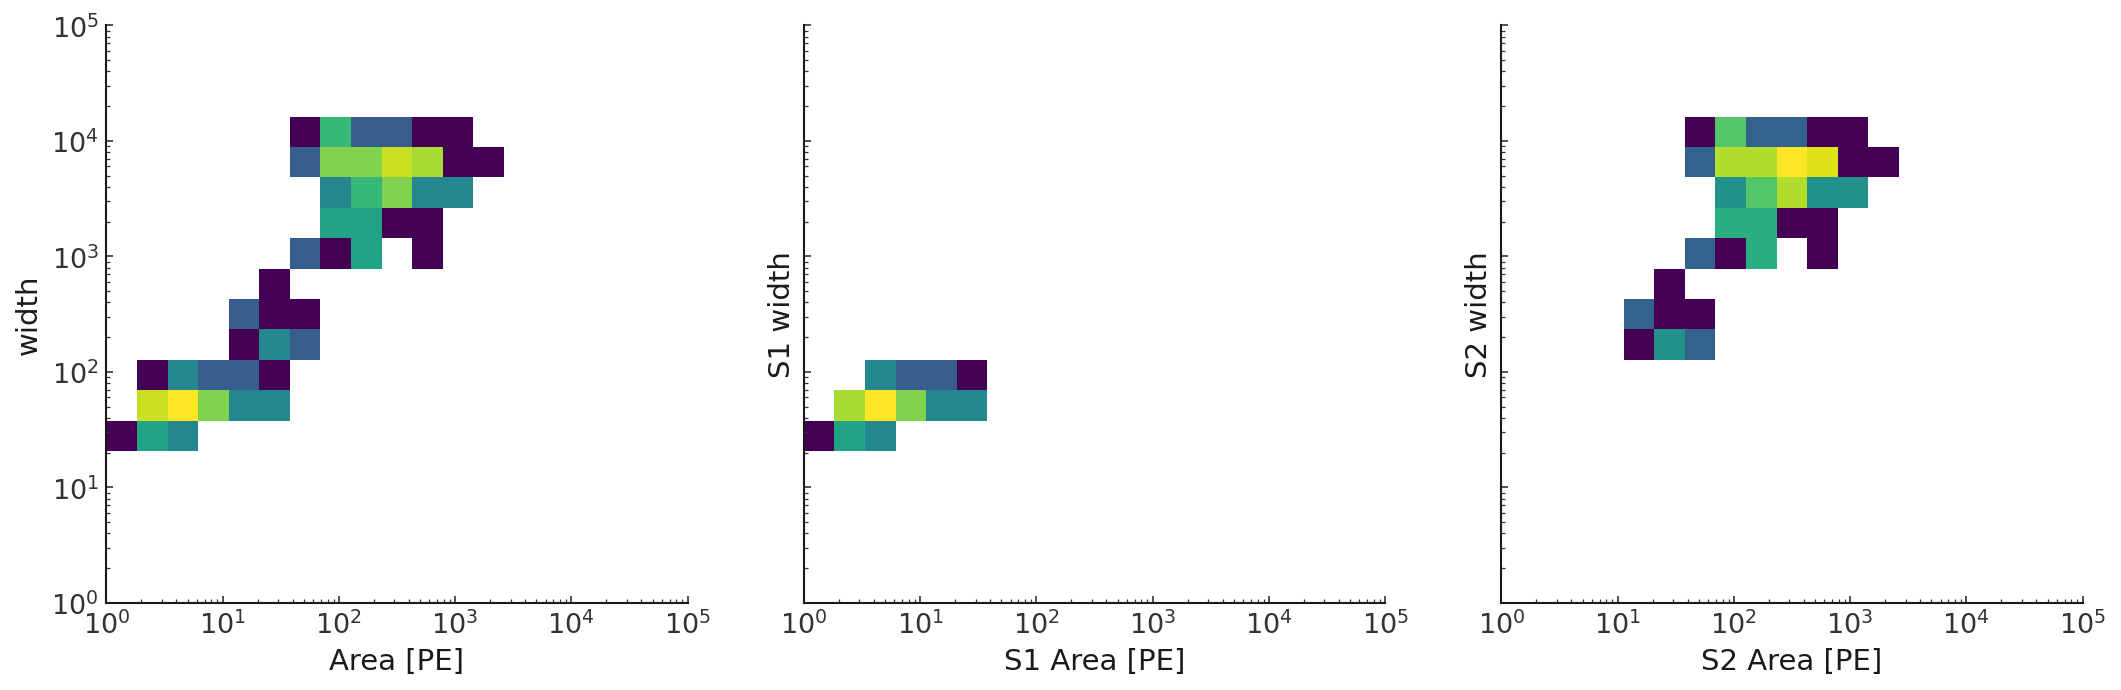

In [22]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(17,5), sharex=True, sharey=True)
ax0.grid(False); ax1.grid(False); ax2.grid(False)
ax0.hist2d(peaks["area"], peaks["range_50p_area"], 
           bins=(np.logspace(0,5,20),np.logspace(0,5,20)),
           norm=LogNorm());
ax0.set_xscale("log"); ax0.set_yscale("log")
ax0.set_xlabel("Area [PE]"); ax0.set_ylabel("width");


ax1.hist2d(peak_s1["area"], peak_s1["range_50p_area"], 
           bins=(np.logspace(0,5,20),np.logspace(0,5,20)),
           norm=LogNorm());
ax1.set_xscale("log"); ax1.set_yscale("log")
ax1.set_xlabel("S1 Area [PE]"); ax1.set_ylabel("S1 width");

ax2.hist2d(peak_s2["area"], peak_s2["range_50p_area"], 
           bins=(np.logspace(0,5,20),np.logspace(0,5,20)),
           norm=LogNorm());
ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xlabel("S2 Area [PE]"); ax2.set_ylabel("S2 width");

In [ ]:
plt.hist2d(peaks[''])

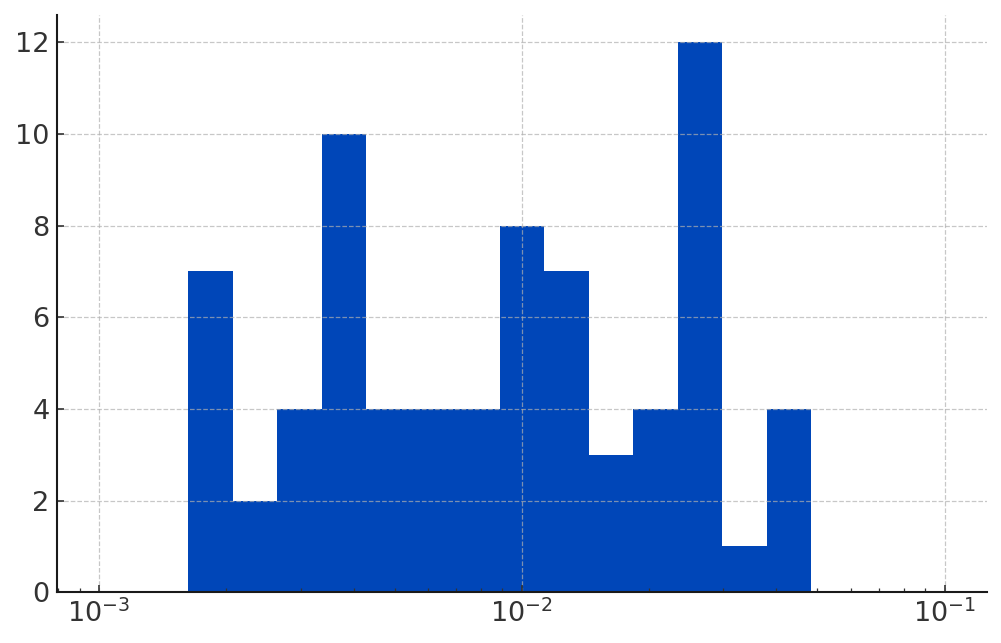

In [33]:
plt.hist((peaks['time']-peaks['time'].min())/np.sum(peaks['time']-peaks['time'].min()), bins=np.logspace(-3,-1,20));
plt.xscale('log')